In [2]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator,DEFAULT_SIZE_GUIDANCE
from PIL import Image
import io
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from src import *

# Preview Tensorboard logs

In [32]:
ROLLING_MEAN=1500
tfevents_file = "trainings/SD1xl_CN_16bs_1e-5lr_8k_combined-loss/logs/sd_xl_train_controlnet/events.out.tfevents.1748560819.lrdn3451.leonardo.local.3256588.0"

In [14]:
# ~5 min
ea = EventAccumulator(tfevents_file, size_guidance={"images": 0, "scalars": 0})
ea.Reload();

In [15]:
tags = ea.Tags()["images"]
cprint("Available image tags:", *[f"green:\n{i}) {x}" for i,x in enumerate(tags)])

Available image tags: 
0) a dark brown, metallic gear with a rough, industrial texture, featuring sharp teeth and a central hole, suggesting a robust and durable design. 
1) a delicate, ornate silver plate with intricate floral patterns and a glossy finish, reflecting light subtly.


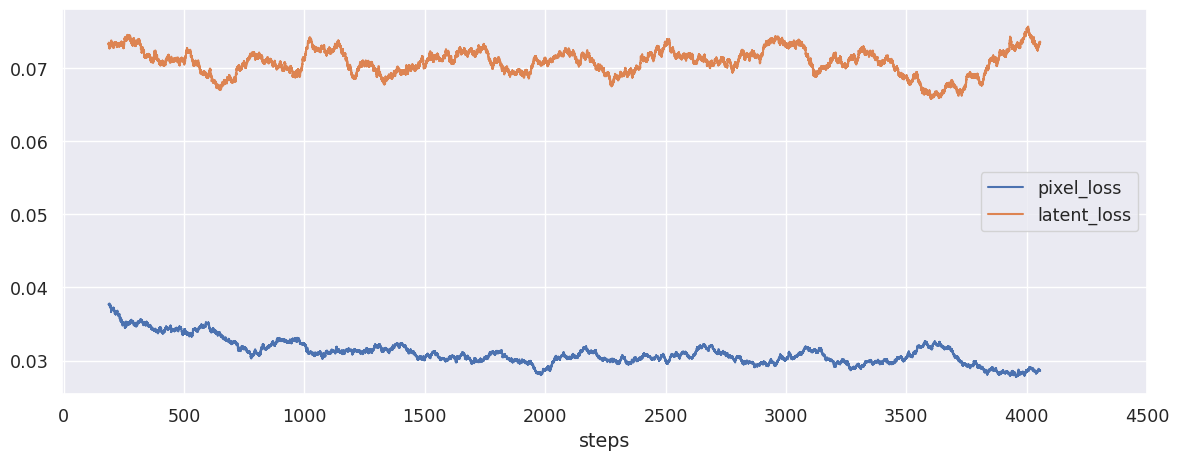

In [33]:
pixel_loss, latent_loss = ea.Scalars("pixel_loss"), ea.Scalars("latent_loss")

df = pd.DataFrame(
    {
        "steps": [x.step for x in pixel_loss],
        "pixel_loss": [x.value for x in pixel_loss],
        "latent_loss": [x.value for x in latent_loss],
    }
)
df["pixel_loss"] = df["pixel_loss"].rolling(ROLLING_MEAN).mean()
df["latent_loss"] = df["latent_loss"].rolling(ROLLING_MEAN).mean()
ax = df.plot(x="steps", figsize=(14, 5))
ax.set_xticks(range(0, 5000, 500));

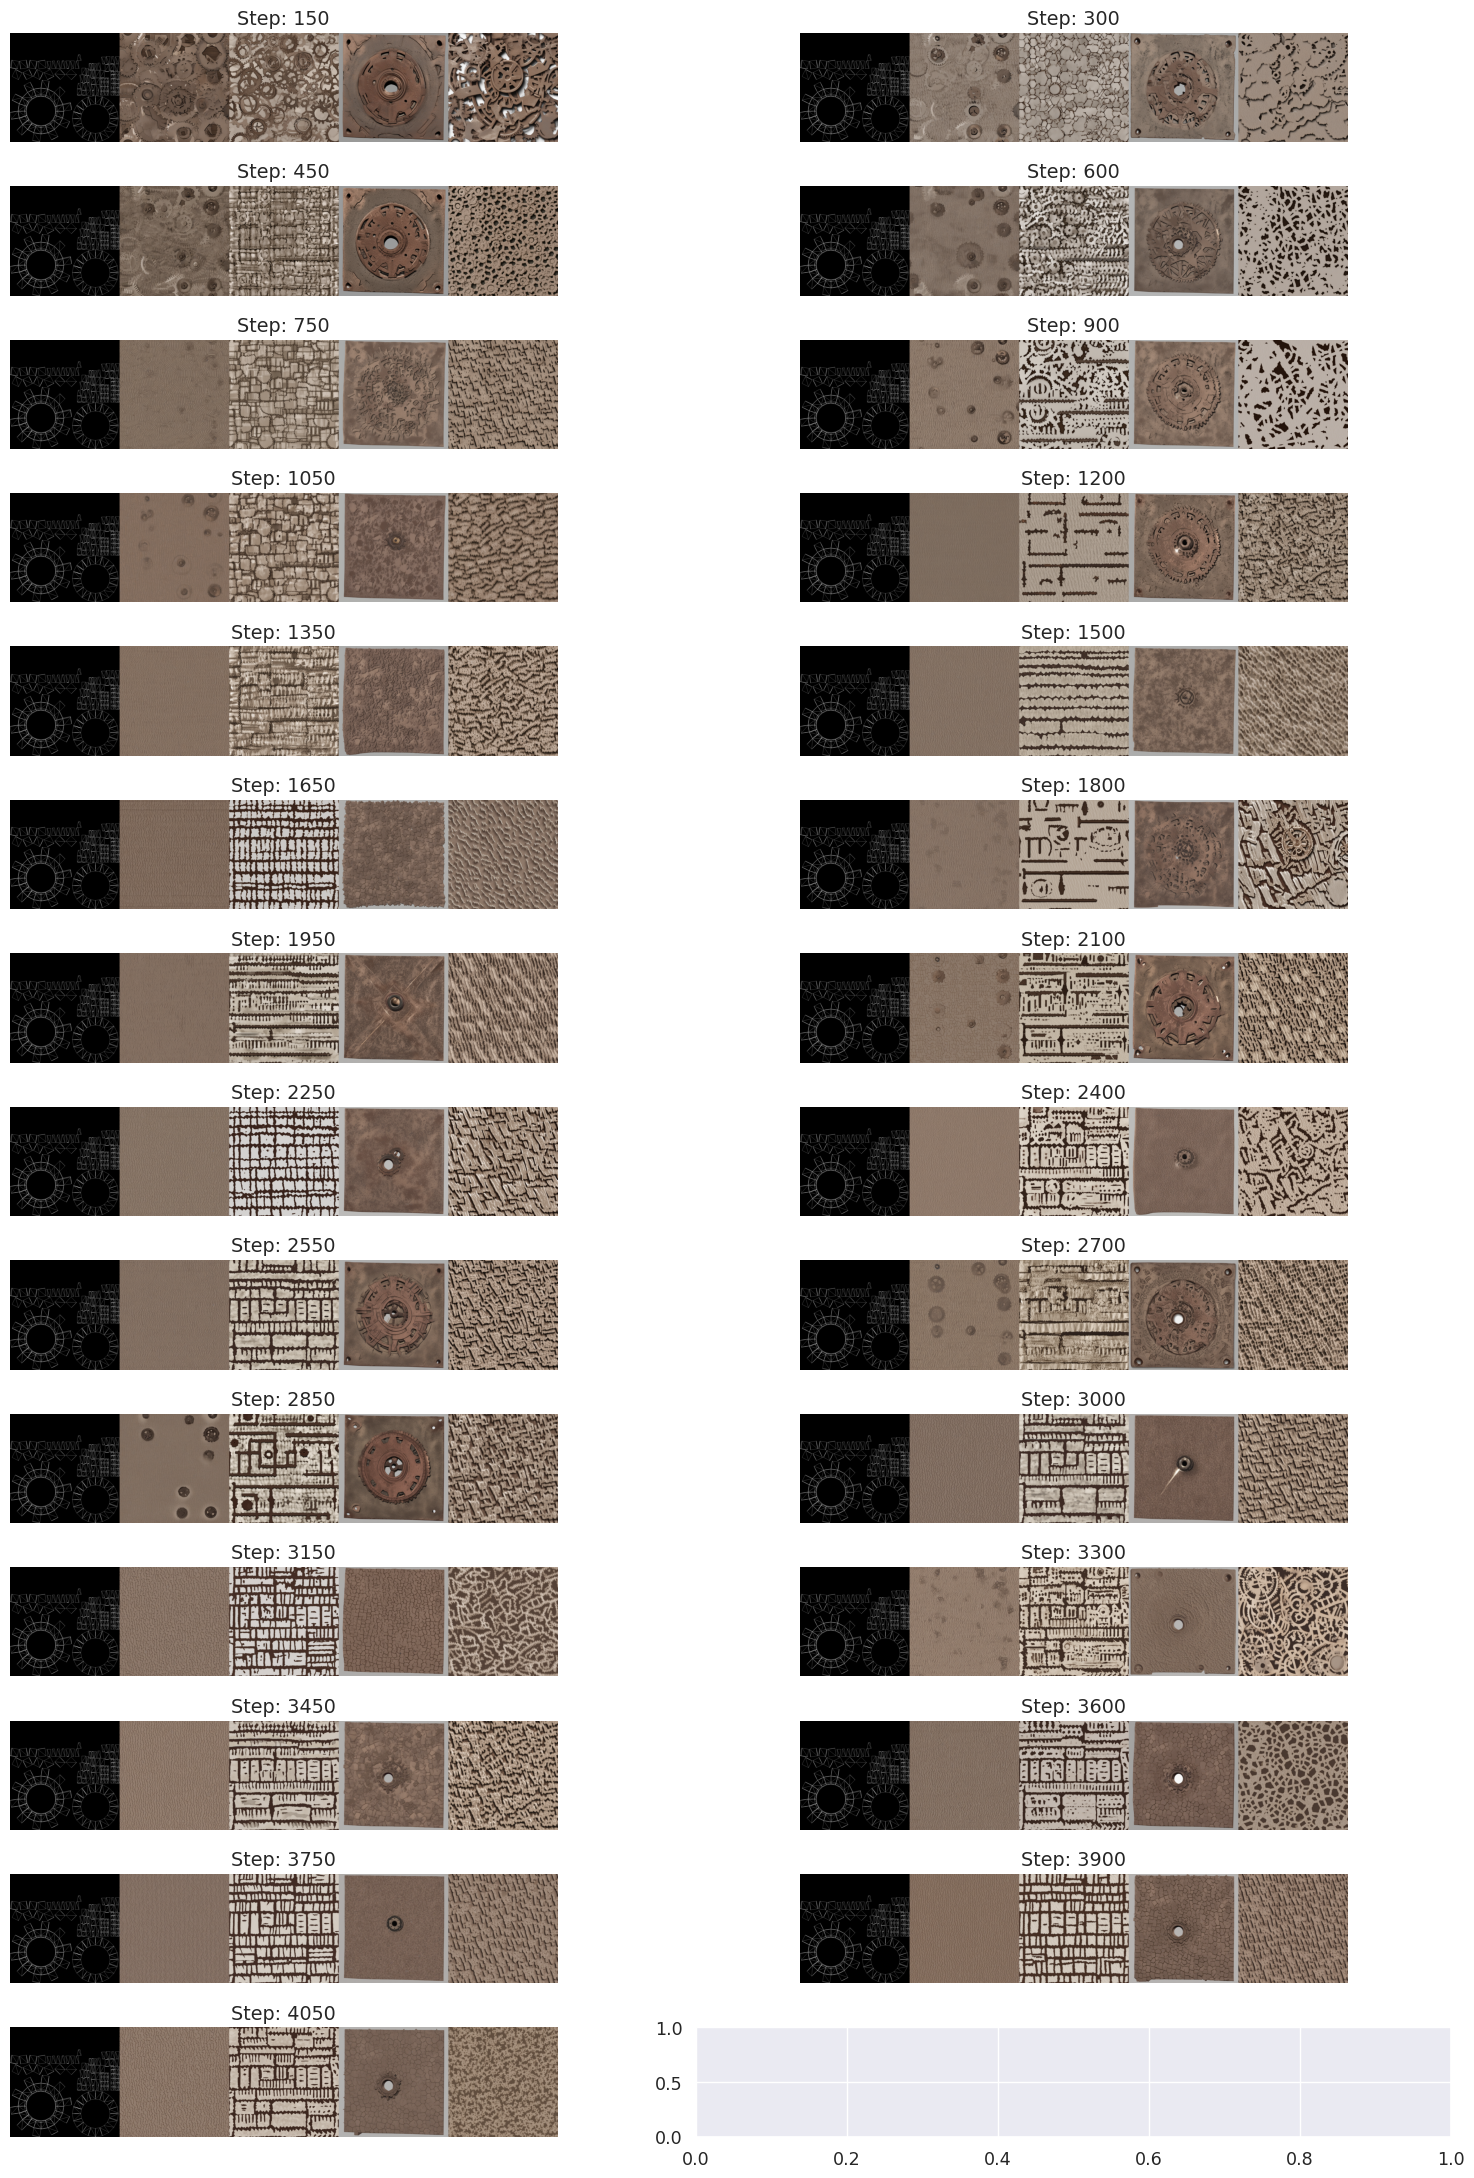

In [26]:
SAMPLE = 0
events = ea.Images(tags[SAMPLE])
to_pil = lambda event: Image.open(io.BytesIO(event.encoded_image_string)).convert("RGB")
plot_images({f"Step: {event.step}": to_pil(event) for event in events}, size=8, cols=2)